In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
from sqlalchemy import inspect
inspector = inspect(engine)

columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

lastdate = 2017-08-23
year_ago = 2016-08-23
results_df:
            date  prcp
0     2016-08-23  0.00
1009  2016-08-23   NaN
1529  2016-08-23  1.79
704   2016-08-23  0.05
361   2016-08-23  0.15


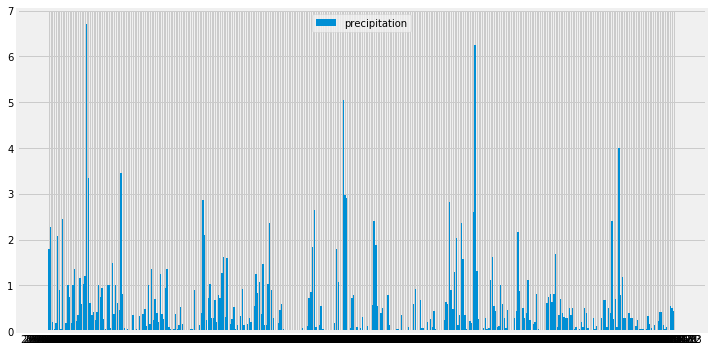

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

sel = [Measurement.date, Measurement.prcp]

# Calculate the date 1 year ago from the last data point in the database

lastdate = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
print(f"lastdate = {lastdate}")
year, month, day = lastdate.split('-')
year = str(int(year)-1)
year_ago = year + '-' + month + '-' + day
print(f"year_ago = {year_ago}")

# Perform a query to retrieve the data and precipitation scores

results = session.query(*sel).filter(Measurement.date >= year_ago).all()

# Save the query results as a Pandas DataFrame and set the index to the date column

results_df = pd.DataFrame(results)
results_df.set_index('date')

# Sort the dataframe by date

results_df = results_df.sort_values(by='date')
print('results_df:')
print(results_df.head())

# Use Pandas Plotting with Matplotlib to plot the data

x_axis = results_df['date']
y_axis = results_df['prcp']
plt.figure(figsize=(10,5))
precip = plt.bar(x_axis, y_axis)

plt.tight_layout()

# Create a legend
plt.legend((precip), ('precipitation',), loc='upper center')

# Save Figure
plt.savefig("Images/Climate_precipitation.png")
plt.show()

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data

results_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [14]:
# Design a query to show how many stations are available in this dataset?
sel = [Station.id]
results = session.query(*sel).count()
results

9

In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

results = session.query(Station.station, func.count(Measurement.station)).\
    filter(Station.station == Measurement.station).\
    group_by(Station.station).\
    order_by(func.count(Measurement.station).desc()).all()
results

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station.

most_active_station = results[0][0]
print(f'Most active station: {most_active_station}')
sel = [func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)]
station_results = session.query(*sel).\
    filter(Station.station == most_active_station).\
    filter(Station.station == Measurement.station).all()
station_results

Most active station: USC00519281


[(54.0, 85.0, 71.66378066378067)]

SELECT measurement.tobs, count(measurement.tobs) AS count_1 
FROM measurement, station 
WHERE station.station = :station_1 AND station.station = measurement.station AND measurement.date >= :date_1 GROUP BY measurement.tobs

tobs_df:
    tobs  count_1
0   59.0        3
1   60.0        2
2   61.0        1
3   62.0        6
4   63.0        4
5   64.0        3
6   65.0        7
7   66.0        5
8   67.0       15
9   68.0       12
10  69.0       19
11  70.0       22
12  71.0       18
13  72.0       22
14  73.0       18
15  74.0       39
16  75.0       33
17  76.0       33
18  77.0       31
19  78.0       22
20  79.0       18
21  80.0       11
22  81.0        4
23  82.0        3
24  83.0        1


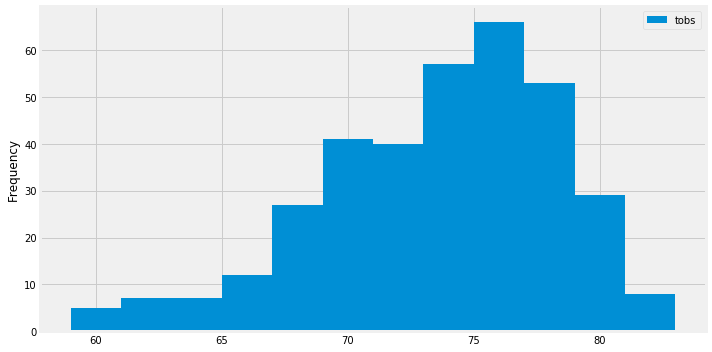

In [17]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

tobs_results = session.query(Measurement.tobs, func.count(Measurement.tobs)).\
    filter(Station.station == most_active_station).\
    filter(Station.station == Measurement.station).\
    filter(Measurement.date >= year_ago).\
    group_by(Measurement.tobs).statement
print(tobs_results)

tobs_df = pd.read_sql_query(tobs_results, session.bind)
print()
print('tobs_df:')
print(tobs_df)

x_axis = tobs_df['tobs']
y_axis = tobs_df['count_1']

plt.figure(figsize=(10,5))
tobs_hist = plt.hist(tobs_df.tobs, weights=tobs_df.count_1, bins=12)

plt.ylabel('Frequency')
plt.legend(('tobs',))

plt.tight_layout()

# Save Figure
plt.savefig("Images/Climate_station_histogram.png")
plt.show()

In [18]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [19]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

start_date = '2017-02-28'
end_date = '2017-03-05'
agg_results = calc_temps(start_date, end_date)
print(agg_results)

[(64.0, 72.02777777777777, 78.0)]


72.02777777777777


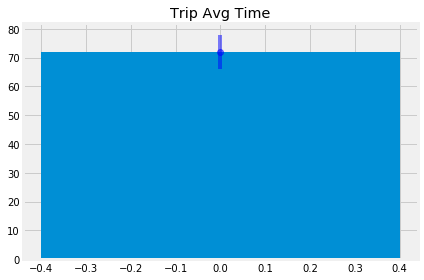

In [20]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

print(agg_results[0][1])

# Use Pandas Plotting with Matplotlib to plot the data

x_axis = 0
y_axis = agg_results[0][1]

means = [agg_results[0][1]]

yerr = [agg_results[0][2] - agg_results[0][1]]

# Plot sample means with error bars
fig, ax = plt.subplots()

ax.errorbar(np.arange(0, 1), means, yerr=yerr, fmt="o", color="b",
            alpha=0.5, label="Trip avg Time")

plt.bar(x_axis, y_axis)
plt.title('Trip Avg Time')

plt.tight_layout()

# Save Figure
plt.savefig("Images/Climate_temperature.png")
plt.show()

In [21]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

# start_date = '2011-02-28'
# end_date = '2011-03-05'
sel = [Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)]
results = session.query(*sel).\
    filter(Station.station == Measurement.station).\
    filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).\
    group_by(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation).\
    order_by(func.sum(Measurement.prcp).desc()).all()
results

[('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  4.720000000000001),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 4.45),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  4.07),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 2.98),
 ('USC00519397',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  2.7399999999999998),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  2.32),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  1.1600000000000001)]

## Optional Challenge Assignment

In [22]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [23]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2018-02-28'
end_date = '2018-03-05'

# Use the start and end date to create a range of dates
from datetime import date, timedelta

year1, month1, day1 = start_date.split('-')
d1 = date(int(year1), int(month1), int(day1))  # start date
year2, month2, day2 = end_date.split('-')
d2 = date(int(year2), int(month2), int(day2))  # end date

delta = d2 - d1         # timedelta

trip_dates = []
for i in range(delta.days + 1):
    print(d1 + timedelta(i))
    trip_dates.append(str(d1 + timedelta(i)))

print(trip_dates)

# Stip off the year and save a list of %m-%d strings
date_list = []
for i in range(len(trip_dates)):
    year, month, day = trip_dates[i].split('-')
    date_list.append(month + '-' + day)

print(date_list)

# Loop through the list of %m-%d strings and calculate the normals for each date
normals = []
tmin_list = []
tavg_list = []
tmax_list = []
for i in range(len(date_list)):
    norm = daily_normals(date_list[i])[0]
    normals.append(norm)
    tmin_list.append(norm[0])
    tavg_list.append(norm[1])
    tmax_list.append(norm[2])


print(tmin_list)
print(tavg_list)
print(tmax_list)
normals

2018-02-28
2018-03-01
2018-03-02
2018-03-03
2018-03-04
2018-03-05
['2018-02-28', '2018-03-01', '2018-03-02', '2018-03-03', '2018-03-04', '2018-03-05']
['02-28', '03-01', '03-02', '03-03', '03-04', '03-05']
[65.0, 64.0, 61.0, 60.0, 57.0, 60.0]
[70.65517241379311, 70.0327868852459, 70.36666666666666, 70.06896551724138, 69.27272727272727, 67.89090909090909]
[80.0, 76.0, 78.0, 78.0, 77.0, 76.0]


[(65.0, 70.65517241379311, 80.0),
 (64.0, 70.0327868852459, 76.0),
 (61.0, 70.36666666666666, 78.0),
 (60.0, 70.06896551724138, 78.0),
 (57.0, 69.27272727272727, 77.0),
 (60.0, 67.89090909090909, 76.0)]

In [24]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

import datetime

start_dt = datetime.datetime.strptime(start_date, '%Y-%m-%d').date()
end_dt = datetime.datetime.strptime(end_date, '%Y-%m-%d').date()
daterange = pd.date_range(start_dt, end_dt)

trip_df = pd.DataFrame( {
    "date": daterange,
    "tmin": tmin_list,
    "tavg": tavg_list,
    "tmax": tmax_list
    } )
trip_df = trip_df.set_index('date')
trip_df

,tmin,tavg,tmax
date,,,
2018-02-28,65.0,70.655172,80.0
2018-03-01,64.0,70.032787,76.0
2018-03-02,61.0,70.366667,78.0
2018-03-03,60.0,70.068966,78.0
2018-03-04,57.0,69.272727,77.0
2018-03-05,60.0,67.890909,76.0


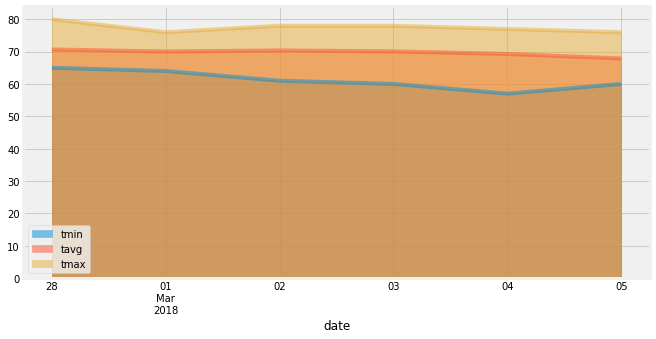

In [25]:
# Plot the daily normals as an area plot with `stacked=False`

plt.figure(figsize=(10,5))
plt.tight_layout()

plot=trip_df.plot.area(xticks=trip_df.index.date, stacked = False, grid=1, ax=plt.gca())

fig = plot.get_figure()

# Save Figure
fig.savefig("Images/Climate_daily_normals.png")

plt.show()